# Preparazione


In [ ]:
# importo tutti i pacchetti necessari al progetto
from google.colab import drive

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
import missingno as msno
from tqdm.notebook import tqdm
import random
import sklearn.utils

# importo modelli
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              IsolationForest)

# metriche e preprocessing
from sklearn.impute import KNNImputer
from sklearn.metrics import (precision_score,
                             accuracy_score,
                             confusion_matrix)
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     cross_validate,
                                     ParameterGrid,
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

import warnings

# imposto random seed
np.random.seed(17)
random.seed(17)
sklearn.utils.check_random_state(17)

RandomState(MT19937) at 0x78A67AEDAE40

In [ ]:
# ottengo la colormap e i colori per i grafici
colors = sns.color_palette("Set3", 12)
colors

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

In [ ]:
# imposto l'opzione display.float_format per evitare le annotazioni scientifiche
pd.set_option('display.float_format', '{:.3f}'.format)

# gestisco le annotazioni scientifiche anche nei grafici
plt.rcParams['axes.formatter.use_mathtext'] = False
plt.rcParams['axes.formatter.limits'] = (-6, 6)

In [ ]:
# permetto l'accesso a gdrive da colab
print("Permettere al blocco note di accedere a Google Drive per poter importare il dataset:")
drive.mount('/content/drive')

Permettere al blocco note di accedere a Google Drive per poter importare il dataset:
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importo il dataset da google drive
file_id = '1tl7kvwbW-KYf67kMeo6I0CxN-JPHIYxW'
link = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(link)

In [ ]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890,20791.319,7.300,368.516,564.309,10.380,86.991,2.963,0
1,3.716,129.423,18630.058,6.635,NaN,592.885,15.180,56.329,4.501,0
2,8.099,224.236,19909.542,9.276,NaN,418.606,16.869,66.420,3.056,0
3,8.317,214.373,22018.417,8.059,356.886,363.267,18.437,100.342,4.629,0
4,9.092,181.102,17978.986,6.547,310.136,398.411,11.558,31.998,4.075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668,193.682,47580.992,7.167,359.949,526.424,13.894,66.688,4.436,1
3272,7.809,193.553,17329.802,8.061,NaN,392.450,19.903,NaN,2.798,1
3273,9.420,175.763,33155.578,7.350,NaN,432.045,11.039,69.845,3.299,1
3274,5.127,230.604,11983.869,6.303,NaN,402.883,11.169,77.488,4.709,1


# Exploratory data analysis

## Analisi Esplorativa

Faccio una breve analisi esplorativa del dataset per capire con cosa ho a che fare ed impostare correttamente il lavoro.

### Documentazione dati
ppm: parts per million μg/L: microgram per litre mg/L: milligram per litre
Column description:
1. ph: pH of 1. water (0 to 14).
2. Hardness: Capacity of water to precipitate soap in mg/L.
3. Solids: Total dissolved solids in ppm.
4. Chloramines: Amount of Chloramines in ppm.
5. Sulfate: Amount of Sulfates dissolved in mg/L.
6. Conductivity: Electrical conductivity of water in μS/cm.
7. Organic_carbon: Amount of organic carbon in ppm.
8. Trihalomethanes: Amount of Trihalomethanes in μg/L.
9. Turbidity: Measure of light emiting property of water in NTU.
10. Potability: Indicates if water is safe for human consumption.

    Potable -1 and
    Not potable -0

Approfondisco il significato dei dati a disposizione:  
(abbreviazioni: WHO = World Heatlth Organizatio, MSI = Ministero della Salute Italiano)

- **ph** rappresenta la misura della concentrazione di ioni di idrogeno (H+) presenti in una soluzione acquosa, varia da 0 (soluzione fortemente acida) a 14 (soluzione fortemente basica). ph 7 indica una soluzione neutra.
Il ph dell'acqua potabile dovrebbe restare in un range tra i 6.5 e 8.5.  
(fonte: [pH in Drinking-water, WHO 2007](https://cdn.who.int/media/docs/default-source/wash-documents/wash-chemicals/ph.pdf?sfvrsn=16b10656_4))

- **Hardness** rappresenta la durezza dell'acqua, ovvero la quantità di sali di magnesio e/o calcio disciolti in acqua. La durezza non incide significativamente sulla potabilità dell'acqua.  
(fonte: [Hardness in Drinking-water, WHO 2010](https://apps.who.int/iris/bitstream/handle/10665/70168/WHO_HSE_WSH_10.01_10_Rev1_eng.pdf)).

- **Solids** rappresenta il numero totali di solidi disciolti nella soluzione (TDS) misurato in parti per milione (ppm). Il valore di TDS non dovrebbe incidere sulla potabilità dell'acqua anche se un valore sotto i 1000 ppm (1000 mg/L) è generalmente preferito.  
(fonte: [Total dissolved solids in Drinking-water, WHO 2003](https://cdn.who.int/media/docs/default-source/wash-documents/wash-chemicals/tds.pdf?sfvrsn=3e6d651e_4)).

- **Chloramines** rappresenta il numero totale di cloramine presenti nell'acqua misurate in ppm. Le cloramine si formano dalla reazione tra il cloro e l'ammoniaca presenti nell'acqua. Sono spesso utilizzate come disinfettante dell'acqua potabile per prevenire la proliferazione di batteri, virus e altri microrganismi nocivi.  
Le linee guida della WHO indicano valori di cloramine sotto a 3mg/L per l'acqua potabile.  
(fonte: [Monochloramine in Drinking-water, WHO 2004](https://cdn.who.int/media/docs/default-source/wash-documents/wash-chemicals/chloramine-backgroundae66824ea038485bb28b2fc44ab88177.pdf?sfvrsn=215eca62_4))

- **Sulfate** rappresenta il numero di sali contenenti l'ione solfato (SO4^2-) presenti in acqua. Hanno effetto sul gusto dell'acqua (valori superiori a 205 mg/L) e sulla salute dell''essere umano (effetti lassativi con valori attorno ai 1000 mg/L). Per questi motivi le linee guida della WHO indicano come limite per l'acqua potabile 500 mg/L di sulfati.  
(fonte: [Sulfate in Drinking-water, WHO 2004](https://cdn.who.int/media/docs/default-source/wash-documents/wash-chemicals/sulfate.pdf?sfvrsn=b944d584_4))

- **Conductivity** indica la capacità dell'acqua di condurre l'elettricità. Viene misurato in microsiemens per centimetro (μS/cm) ed è una misura indiretta della quantità di ioni disciolti presenti nell'acqua, che determina la sua capacità di condurre corrente elettrica. Tendenzialmente minore è il valore di conducibilità e maggiore è la sua potabilità. Il limite della conducibilità per l'acqua potabile varia in base alla regolamentazione di ogni Paese, in Italia il limite è di 2500 (μS/cm).  
(fonte: [Conduttivita, MSI 2016](https://www.salute.gov.it/portale/temi/documenti/acquepotabili/parametri/CONDUTTIVITA.pdf))

- **Organic_carbon** indica la concentrazione di carbonio organico disciolto nell'acqua misurato in ppm. Questo parametro fornisce informazioni sulla presenza di sostanze organiche disciolte. In Italia il limite massimo per legge di carbonio organico in acqua destinata al consumo umano è di 10 mg/L che corrispondono a 10 ppm. Questo valore puù cambiare leggermente nei diversi Stati.   
(fonte: [Carbonio organico totale, MSI 2016](https://www.salute.gov.it/portale/temi/documenti/acquepotabili/parametri/CARBONIO_ORGANICO_TOTALE.pdf))

- **Trihalomethanes** (THM) sono un gruppo di composti chimici formati dalla reazione tra il cloro utilizzato per la disinfezione dell'acqua e la materia organica presente nell'acqua, come ad esempio residui vegetali o prodotti di degradazione organica. I THM includono composti come il cloroformio, il bromodichlorometano, il bromoformio e il dibromoclorometano.
La WHO ha stabilito un valore massimo di 200 μg/L ma l'Unione Europea e di conseguenza l'Italia hanno adottato misure più stringenti abbassando il limite trialometanoli nell'acqua potabile a 30 μg/L.  
(fonte: [Trihalomethanes in Drinking-water, WHO 2004](https://cdn.who.int/media/docs/default-source/wash-documents/wash-chemicals/trihalomethanes.pdf?sfvrsn=3d3a90e3_4);  [Trialometani, MSI 2016](https://www.salute.gov.it/portale/temi/documenti/acquepotabili/parametri/TRIALOMETANI.pdf))

- **Turbidity** è una misura della quantità di particelle sospese nell'acqua che influisce sulla sua trasparenza o chiarezza. Viene misurata in unità di Nephelometric Turbidity Units (NTU). Minore è la torbidità e maggiore è la potabilità dell'acqua. La WHO indica come 5 NTU il limite consigliato per considerabile sicura l'acqua.  
(fonte: [Water quality and health - review of turbidity, WHO 2017](https://apps.who.int/iris/bitstream/handle/10665/254631/WHO-FWC-WSH-17.01-eng.pdf))




In [ ]:
# guardo le dimensioni del dataset
df.shape

(3276, 10)

In [ ]:
# guardo alcuni campioni di esempio
df.sample(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1471,7.584,217.283,36343.407,8.533,375.964,393.878,17.442,77.722,3.642,0
861,NaN,184.751,28499.107,6.550,330.720,381.502,11.044,62.015,3.403,0
248,6.582,272.983,37169.444,8.115,416.083,351.477,15.129,79.261,4.202,0
1346,5.589,171.333,17732.241,5.589,343.042,466.445,13.828,59.376,4.374,0
2539,7.284,197.602,23112.504,9.503,332.332,449.362,14.459,70.000,3.572,0


In [ ]:
# panoramica generale del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000,3276.000,3276.000,3276.000,2495.000,3276.000,3276.000,3114.000,3276.000,3276.000
mean,7.081,196.369,22014.093,7.122,333.776,426.205,14.285,66.396,3.967,0.390
std,1.594,32.880,8768.571,1.583,41.417,80.824,3.308,16.175,0.780,0.488
min,0.000,47.432,320.943,0.352,129.000,181.484,2.200,0.738,1.450,0.000
25%,6.093,176.851,15666.690,6.127,307.699,365.734,12.066,55.845,3.440,0.000
50%,7.037,196.968,20927.834,7.130,333.074,421.885,14.218,66.622,3.955,0.000
75%,8.062,216.667,27332.762,8.115,359.950,481.792,16.558,77.337,4.500,1.000
max,14.000,323.124,61227.196,13.127,481.031,753.343,28.300,124.000,6.739,1.000


In [ ]:
# controllo il numero di valori unici per distinguere variabili categoriche e continue
df.nunique()

ph                 2785
Hardness           3276
Solids             3276
Chloramines        3276
Sulfate            2495
Conductivity       3276
Organic_carbon     3276
Trihalomethanes    3114
Turbidity          3276
Potability            2
dtype: int64

In [ ]:
# controllo valori nulli
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
# percentuale valori nulli
df_na_perc = (df.isna().sum() /
              df.shape[0] *
              100)

df_na_perc

ph                14.988
Hardness           0.000
Solids             0.000
Chloramines        0.000
Sulfate           23.840
Conductivity       0.000
Organic_carbon     0.000
Trihalomethanes    4.945
Turbidity          0.000
Potability         0.000
dtype: float64

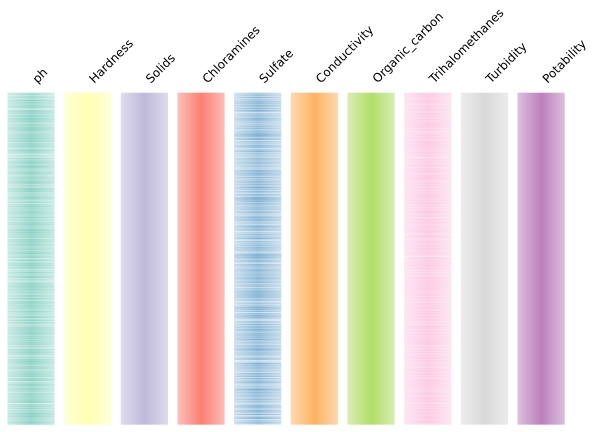

In [ ]:
# rappresento graficamente i valori mancanti

fig, ax = plt.subplots(figsize=(10, 6), ncols=len(df.columns))
for i, col in enumerate(df.columns):
    msno.matrix(df[col].to_frame(),
                color=colors[i],
                ax=ax[i],
                fontsize=12,
                sparkline=False)
    ax[i].set_yticks([])  # rimuovo etichette asse y


plt.show()

In [ ]:
# osservo il bilanciamento delle classi
class_count = df["Potability"].value_counts()
print(class_count)

0    1998
1    1278
Name: Potability, dtype: int64


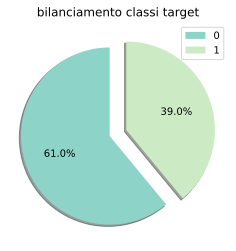

In [ ]:
# creo il grafico a torta
plt.figure(figsize=(4, 4))
plt.pie(
    class_count,
    colors=(colors[0], colors[10]),
    autopct="%1.1f%%",
    startangle=90,
    shadow=True,
    explode=[0.1,0.1]

)
plt.title("bilanciamento classi target")
plt.legend([0,1], )
plt.show()

### Conclusioni analisi esplorativa:

- il dataset è composta da 3276 campioni e da 10 colonne (9 features ed un target)
- La label è categorica binaria e rappresenta se l'acqua è potabile o meno (dalla documentazione: 0 = non potabile, 1 = potabile)
- La label è numerica (int64)
- le classi 0 ed 1 della label non sono bilanciate. Sono presenti più campioni con Potability = 0 (1998 - 61%) ovvero non potabile, rispetto che a 1 (1278 - 39%), ovvero acqua potabile.
- le 9 features rappresentano vari valori misurati nell'acqua che possono incidere sulla potabilità
- tutte le features sono numeriche (float64) e sono continue
- sono presenti valori mancanti nelle features: ph, Sulfate e Trihalomethanes. Rispettivamente il 15%, il 23% ed il 5% dei campioni totali.
- le features non sono nè scalate nè centrate.
- Si notano valori della feature "Solids" molto più alti di quelli attesi (soglia consigliata per acqua potabile da WHO = 1000 ppm, valore medio Solids = 22000 ppm). Inoltre, valori così alti di TDS sono generalmente correlati ad un aumento della conducibilità dell'acqua (alto numero di sali disciolti), ma i valori di conducibilità sono relativamente normali.  
Probabilmente questo fenomeno è causato da un errore nell'unità di misura che dovrebbe risolversi con la normalizzazione dei dati.


## Fasi di lavoro

In base alle considerazioni sopra elencate procedo alle seguenti operazioni per eseguire l'analisi:
- **divisione del dataset in training e test set.** (questo mi permette di avere una porzione di dati su cui valutare il modello alla fine dell'ottimizzazione e di poter capire se è in grado di generalizzare correttamente su nuovi dati. Eseguo la divisione come prima cosa per non rischiare di corrompere i dati originali con le varie trasformazioni che andrò ad eseguire)
- **Identificazione base line model.** (Identifico un modello come baseline in modo da poterlo addestrare sui dati ancora grezi ed avere un riferimento nelle operazioni di preprocessing.)
- **bilanciamento dataset** (bilancio le classi del target (potabile - non potabile) in modo che il modello impari a distinguere in ugual modo le due classi e non ci sia preferenza su quella più rappresentata)
- **identificazione e gestione dei valori nulli o mancanti.** (i valori nulli potrebbero dare problemi a diversi modelli (anche durante l'identificazione degli outliers), vado quindi a gestirli eliminandoli o sostituendoli.)
- **identificazione e gestione degli outliers.** (gestisco la presenza di valori anomali nei dati. Identifico sia outliers univariati che multivariati)
- **standardizzazione features** (rendo uniformi le dimensioni dei dati delle diverse features in modo che abbiano un impatto sul modello proporzionato alla variazione e non alla dimensione.)

- **correlazioni** (rappresento una matrice di correlazione tra le diverse features e tra le features ed il target per identificare correlazioni lineari e possibili problemi di multicollinearità)
- **feature selection** (analizzo l'importanza di ogni features nel portare informazioni utili alla previsione del target e nel caso elimino alcune features che potrebbero aumentare il rumore dei dati.)

## Split set


Vado a splittare il dataset in dataset_train e dataset_test.
Divido il dataset con una proporzione tra train e test di 80 a 20 (80% dei campioni nel training set ed il 20 nel test set) in modo da avere abbastanza campioni del training set per poter addestrare il modello ed allo stasso tempo avere un sottoinsieme di campioni sufficientemente grande per il test set in modo che sia rappresentativo dell'intero dataset.  
Imposto un random state fisso e mescolo il dataset prima di eseguire lo split.  

Eseguo una divisione stratificata sul target in modo da mantenere la stessa proporzione tra campioni "potabile" e "non potabile". Questo mi permette di avere la sicurezza di mantenere un adeguato numero di campioni di entrambe le classi nei due nuovi dataset.



In [ ]:
# divido il dataset in train e test set
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=17,
    shuffle=True,
    stratify=df["Potability"])

In [ ]:
# bilanciamento percentuale delle classi
train_bil = df_train["Potability"].value_counts() / df_train["Potability"].count()

print("bilanciamento classi Potability in df_train:")
print(train_bil)

bilanciamento classi Potability in df_train:
0   0.610
1   0.390
Name: Potability, dtype: float64


In [ ]:
# controllo rapporto dimensionale train test
train_size_perc = round((df_train.shape[0] / df.shape[0]),2)
test_size_perc = round((df_test.shape[0] / df.shape[0]),2)

print(f"dimensione df_train rispetto a df = {train_size_perc}")
print(f"dimensione df_test rispetto a df = {test_size_perc}")

dimensione df_train rispetto a df = 0.8
dimensione df_test rispetto a df = 0.2


Il bilanciamento delle classi si è mantenuto, 61/39.

Il rapporto dimensionale tra train e test set è di 8/2.

## Base line model

Setto un modello di classificazione come baseline model, in questo caso scelgo un modello Logistic Regression in quanto è relativamente semplice e veloce da implementare ed addestrare.

Successivamente lo andrò ad addestrare sui dati ancora grezzi per avere un riferimento durante le modifiche di preprocessing.

Imposto max_iter=1000 (default=100) per essere sicuro che il modello arrivi a convergenza.  
Setto un random state fisso in modo da rendere ripetibili i risultati.  
Imposto multi_class= "ovr" in quanto il dataset in questione ha un target categorico binario.



In [ ]:
baseline_model = LogisticRegression(max_iter=1000,
                                    random_state=17,
                                    multi_class="ovr")


## Bilanciamento Dataset

Procedo ora ad una fase di oversampling della classe meno rappresentata in modo da ottenere training set bilanciato (con il 50% dei campioni con Potability = 0 ed il 50% dei campioni con Potability = 1).   
Questo permetterà di ottimizzare l'apprendimento dei modelli senza sovrastimare una delle due classi.


In [ ]:
# conto campioni non potabili in df_train
campioni_non_pota = df_train.loc[
    df_train["Potability"] == 0,
    "Potability"
].count()
print("campioni acqua non potabile: ", campioni_non_pota)

campioni acqua non potabile:  1598


In [ ]:
# conto campioni potabili in df_train
campioni_pota = df_train.loc[
    df_train["Potability"] == 1,
    "Potability"
].count()
print("campioni acqua potabile: ", campioni_pota)

campioni acqua potabile:  1022


Uso la funzione resample di sklearn per bilanciare il dataset. La funzione mi permette di eseguire il bootstrap del dataset, ovvero di ottenere n campioni casuali presi con sostituzione. Prendo i campioni della classe meno rappresentata (Potability=1) e li ricampiono con sostituzione in modo da pareggiare il numero di campioni appertenete alle due classi.

In [ ]:
# ricampiono potability=1
df_train_1 = resample(
    df_train.loc[df_train["Potability"] ==1],
    n_samples=campioni_non_pota,
    replace=True,
    random_state=17
)

# separo potability=0
df_train_0 = df_train.loc[df_train["Potability"]==0]

# unisco i dati
df_train_aug = pd.concat([df_train_0, df_train_1]
                         ).reset_index(drop=True)

In [ ]:
# verifico il bilanciamento delle classi
class_count_aug = df_train_aug["Potability"].value_counts()
print(class_count_aug)

0    1598
1    1598
Name: Potability, dtype: int64


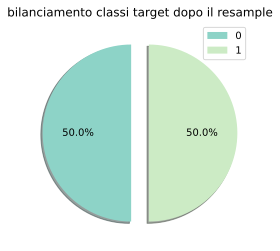

In [ ]:
# creo il grafico a torta del bilanciamento
plt.figure(figsize=(4, 4))
plt.pie(
    class_count_aug,
    colors=(colors[0], colors[10]),
    autopct="%1.1f%%",
    startangle=90,
    shadow=True,
    explode=[0.1,0.1]

)
plt.title("bilanciamento classi target dopo il resample")
plt.legend([0,1], )
plt.show()

In [ ]:
# separo X da y
X_train = df_train_aug.drop(columns="Potability")
y_train = df_train_aug["Potability"]
X_test = df_test.drop(columns="Potability")
y_test = df_test["Potability"]

## Valori mancanti

Vado a gestire i valori mancanti presenti nel dataset.

Procedo all'imputazione dei valori mancanti mediante l'utilizzo del modello KNNImputer che permette di sostituire i valori mancanti con un valori idonei in base alle features dei campioni più simili.

Verifico il bilanciamento dei valori mancanti tra le classi della label

ph: valori mancanti potabile:     208
ph: valori mancanti non potabile: 253
Sulfate: valori mancanti potabile:     352
Sulfate: valori mancanti non potabile: 375
Trihalomethanes: valori mancanti potabile:     69
Trihalomethanes: valori mancanti non potabile: 80


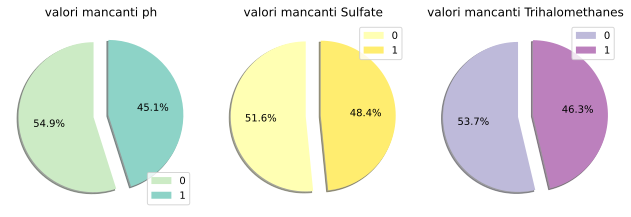

In [ ]:
# imposto il grafico
fig, ax = plt.subplots(figsize=(9,3), ncols=3)

 # imposto colori grafico
plot_colors=[[colors[10],colors[0]],  # coppia verdi
             [colors[1], colors[11]], # coppia gialli
             [colors[2], colors[9]]]  # coppia viola

for i, col in enumerate(["ph", "Sulfate", "Trihalomethanes"]):

    # calcolo totale dei valori mancanti per le due classi
    missing_valous_pota = df_train_aug.loc[df_train_aug["Potability"]==1][col].isna().sum().sum()
    missing_valous_nonpota = df_train_aug.loc[df_train_aug["Potability"]==0][col].isna().sum().sum()

    # stampo a schermo
    print(f"{col}: valori mancanti potabile:     {missing_valous_pota}")
    print(f"{col}: valori mancanti non potabile: {missing_valous_nonpota}")

    ax[i].pie(
        [missing_valous_nonpota, missing_valous_pota],
        colors=plot_colors[i],
        autopct="%1.1f%%",
        startangle=90,
        shadow=True,
        explode=[0.1,0.1]
    )
    ax[i].set_title(f"valori mancanti {col}")
    ax[i].legend([0,1])

plt.tight_layout()
plt.show()

Sembra essere presente un leggero sbilanciamento dei valori mancanti probabilmente dovuto alla componente di caso durante la fase di oversampling.

Lo sbilanciamento non è molto marcato e non sembra essere rilevante ai fini dell'analisi.


Procedo all'imputazione con KNNImputer.

Ottimizzo gli iperparametri di KNNImputer andando a valutare l'apprendimento del baseline model.

Per ogni combinazione di parametri di KNNImputer creo una versione diversa di X_train su cui addestro il baseline model e calcolo l'accuratezza e la precisione.  

Vado poi a mantenere la versione di X_train che ha ottenuto i migliori punteggi.

In [ ]:
# imputazione con KNNImputer

# creo liste in cui salvare df modificati
X_train_imp = []
X_test_imp = []

# creo griglia degli iperparametri da validare
param_grid = {
    'n_neighbors': np.arange(1,21,2),
    'weights': ['uniform', 'distance']
}

# creo tutte le possibili combinazioni di iperparametri
param_combinations = ParameterGrid(param_grid)

# creo le diverse versioni di df
for i, params in tqdm(enumerate(param_combinations),
                      total=len(param_combinations)):

    # addestro su X_train
    imputer = KNNImputer(**params).fit(X_train)

    # trasformo X_train
    X_train_imp += [
        pd.DataFrame(imputer.transform(X_train),
                     columns=X_train.columns).reset_index(drop=True)
                     ]
    # trasformo X_test (info solo da X_train)
    X_test_imp += [
        pd.DataFrame(imputer.transform(X_test),
                     columns=X_test.columns).reset_index(drop=True)
                     ]


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# addestro i modelli sulle diverse versioni di X_train

baseline_imp_acc = []
baseline_imp_prec = []
for i in tqdm(range(len(X_train_imp)),
              total=len(X_train_imp)):

    baseline_model.fit(X_train_imp[i], y_train)
    y_pred = baseline_model.predict(X_test_imp[i])
    baseline_imp_acc += [accuracy_score(y_test, y_pred)]
    baseline_imp_prec += [precision_score(y_test, y_pred)]





  0%|          | 0/20 [00:00<?, ?it/s]

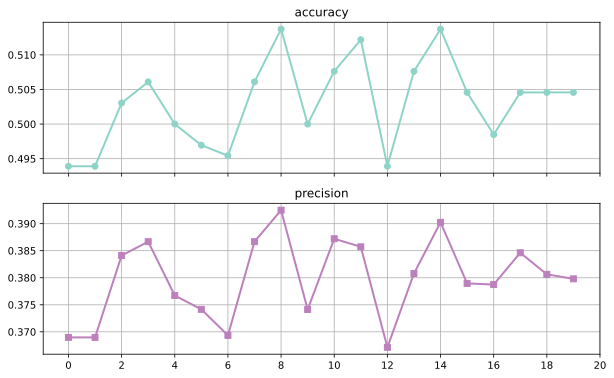

In [ ]:
fig, ax = plt.subplots(figsize=(10,6), sharex=True, nrows=2)

ax[0].plot(baseline_imp_acc,
           color=colors[0],
           linewidth=2,
           marker="o")
ax[1].plot(baseline_imp_prec,
           color=colors[9],
           linewidth=2,
           marker="s")

# imposto grafici
ax[0].set_xticks(range(0,21,2))
ax[0].set_title("accuracy")
ax[1].set_title("precision")
ax[0].grid()
ax[1].grid()


Il migliore risultato si è avuto al tentativo numero 8, con accuratezza di circa 0.515 e precisione di circa 0.394.

In [ ]:
# stampo migliori parametri
print(f"I parametri di KNNImputer migliori sono: \n {param_combinations[8]}")

I parametri di KNNImputer migliori sono: 
 {'weights': 'uniform', 'n_neighbors': 9}


In [ ]:
# salvo i migliori dataset
X_train_imputed = X_train_imp[8]
X_test_imputed = X_test_imp[8]

In [ ]:
# verifico l'assenza di valori mancanti
X_train_imputed.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

Per essere sicuro che l'imputazione non habbia modificato eccessivamente li informazioni presenti nel dataset, plotto le distribuzioni delle features imputate con e senza imputazioni e le metto a confronto.

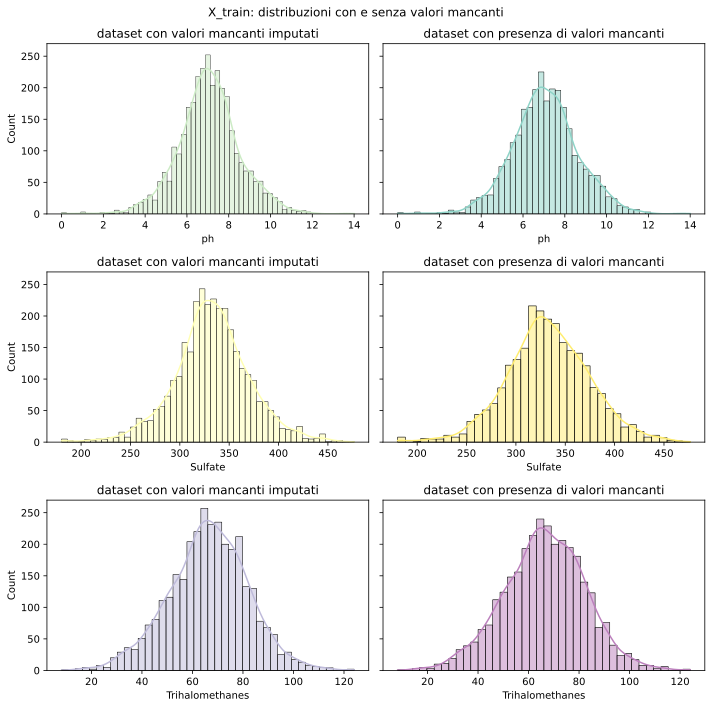

In [ ]:
# confronto distribuzione dati con e senza valori mancanti
fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=3, sharey=True)

plt.suptitle("X_train: distribuzioni con e senza valori mancanti")
features=["ph", "Sulfate", "Trihalomethanes"]

for i, feature in enumerate(features):

    sns.histplot(data=X_train_imputed[feature],
                kde=True,
                ax=ax[i][0],
                color=plot_colors[i][0])
    ax[i][0].set_title("dataset con valori mancanti imputati")

    sns.histplot(data=X_train[feature],
                kde=True,
                ax=ax[i][1],
                color=plot_colors[i][1])
    ax[i][1].set_title("dataset con presenza di valori mancanti")

plt.tight_layout()

Le features con valori imputati hanno mantenuto una distribuzione dei dati molto simile rispetto a prima dell'imputazione, con una forma a campana centrata.   
Dopo l'imputazione la forma della campana risulta leggermente più appuntita ma non viene modificata in modo significativo.

Questo indica che l'imputazione con KNNImputer ha avuto successo, andando a sostituire i valori mancanti con valori coerenti con il dataset.

## Outliers

Eseguo due analisi differenti per gli outliers: univariata con tecnica dell' IQR ed analisi multivariata con modello IsolationForest.

Confronto poi i risultati con il baseline model e mantengo il risultato migliore

### Analisi univariata


Controllo le features singolarmente generando grafici della distribuzione e boxplot. Vado poi ad identificare i possibili outliers con la tecnica del IQR (InterQuartile Range).

Unisco X_train_imputed e y_train per lavorare piu agevolmente sui dati in base alla loro classe del label

In [ ]:
# unisco X_train_imputed e y_train
df_train_imp = pd.concat(
    [X_train_imputed, y_train],
    axis=1
    ).reset_index(drop=True)

In [ ]:
df_train_imp.sample(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2318,6.964,180.402,12878.176,6.424,314.162,358.516,16.330,66.303,4.490,1
331,8.394,187.643,10603.098,7.840,352.836,376.241,13.375,58.950,2.834,0
3138,5.745,208.070,19457.639,6.694,343.375,362.062,15.604,82.318,3.534,1
2112,8.077,125.303,23931.283,8.773,317.693,398.329,15.280,62.668,4.280,1
607,9.131,226.404,19968.678,5.724,386.700,440.543,11.752,58.874,5.288,0


#### Distribuzione

Creo i grafici delle distribuzioni delle feature in modo da poter avere una visione complessiva dei dati.

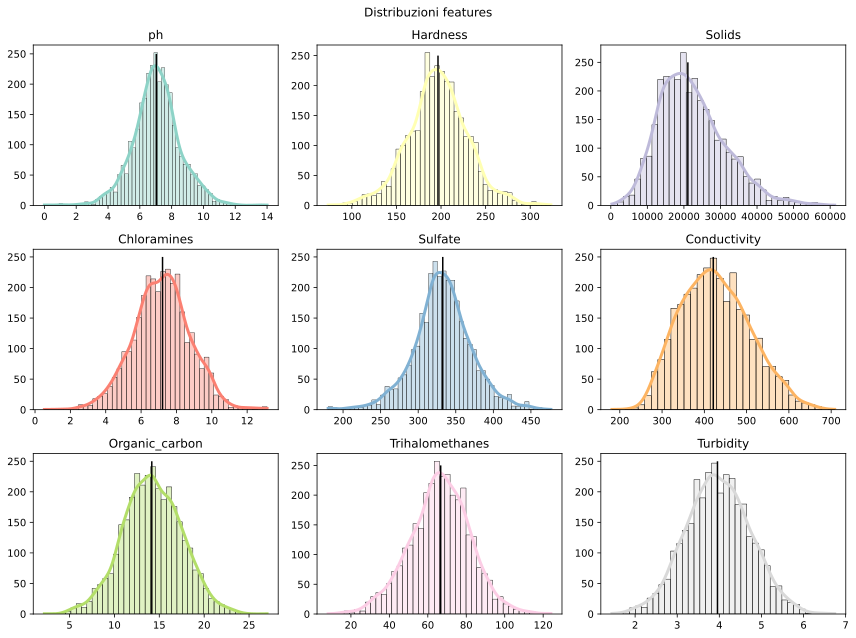

In [ ]:
# imposto figura
fig, axs = plt.subplots(
    figsize=(12, 9),
    nrows=3,
    ncols=3
)
axs = axs.ravel()

# imposto gli histplot
for i, col in enumerate(df_train_imp.columns[:-1]):
    sns.histplot(
        df_train_imp,
        x=df_train_imp[col],
        color=colors[i],
        ax=axs[i],
        kde=True,
        line_kws={"linewidth": 3},
        alpha=0.4
    )
    # traccio mediana
    axs[i].vlines(
        df_train_imp[col].median(),
        ymin=0,
        ymax=250,
        color="k")

    # imposto titolo e labels
    axs[i].set_title(col)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

plt.suptitle("Distribuzioni features")

plt.tight_layout()

Rappresento anche le distribuzioni delle features divise per le classi della label in modo da poter cogliere possibili differenze.

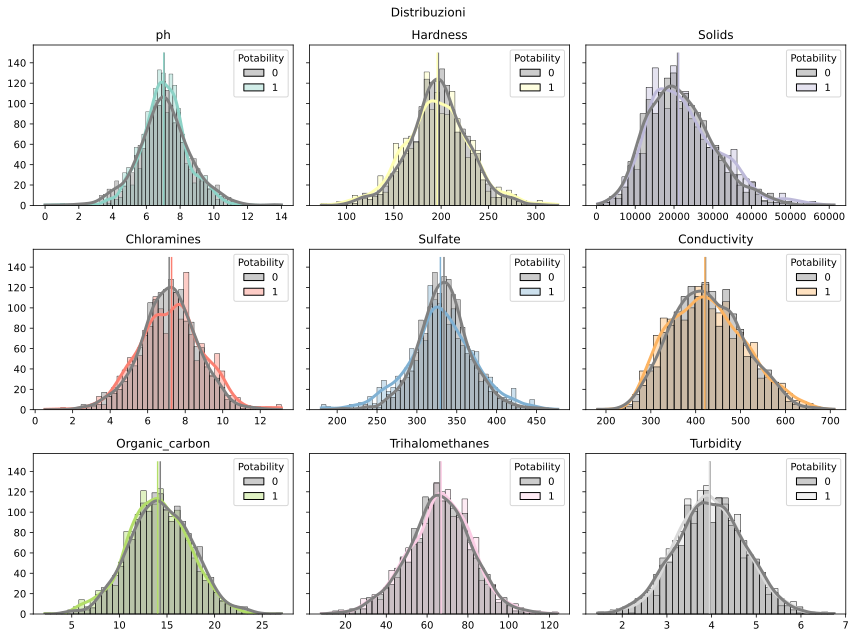

In [ ]:
# imposto figura
fig, axs = plt.subplots(
    figsize=(12, 9),
    nrows=3,
    ncols=3,
    sharey=True
)
axs = axs.ravel()

# imposto gli histplot
for i, col in enumerate(df_train_imp.columns[0:-1]):
    sns.histplot(
        df_train_imp,
        x=df_train_imp[col],
        hue="Potability",
        palette=("gray",colors[i]),
        ax=axs[i],
        kde=True,
        line_kws={"linewidth": 3},
        alpha=0.4
    )
    # traccio mediana 0
    axs[i].vlines(
        df_train_imp[col].loc[df_train_imp["Potability"]==0].median(),
        ymin=0,
        ymax=150,
        color="gray")

    # traccio mediana 1
    axs[i].vlines(
        df_train_imp[col].loc[df_train_imp["Potability"]==1].median(),
        ymin=0,
        ymax=150,
        color=colors[i])

    # imposto titolo e labels
    axs[i].set_title(col)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

plt.suptitle("Distribuzioni")

plt.tight_layout()

L'andamento delle distribuzioni di tutte le features sembra essere centrato e con andamento a campana simmetrica.
L'unica feature che ha una distribuzione con andamento leggermente asimmetrico è "Solids" che ha la coda di destra più lunga.




#### Boxplot

Creo un boxplot per ogni feature in modo da osservare mediana, primo e tezo quartile ed outliers nei dati.

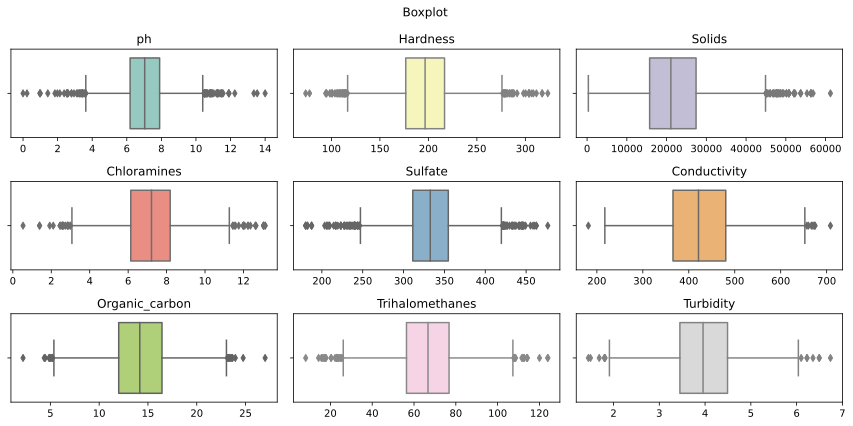

In [ ]:
# imposto figura
fig, axs = plt.subplots(
    figsize=(12, 6),
    nrows=3,
    ncols=3,
    sharey=True
)
axs = axs.ravel()

# imposto gli histplot
for i, col in enumerate(df_train_imp.columns[0:-1]):
    sns.boxplot(
        df_train_imp,
        x=df_train_imp[col],
        orient="h",
        color=colors[i],
        ax=axs[i]
    )

    # imposto titolo e labels
    axs[i].set_title(col)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

plt.suptitle("Boxplot")

plt.tight_layout()

Divido i boxplot in base alle classi della label in modo da identificare possibili differenze tra i dati inerenti all'acqua potabile e quelli inerenti all'acqua non potabile.

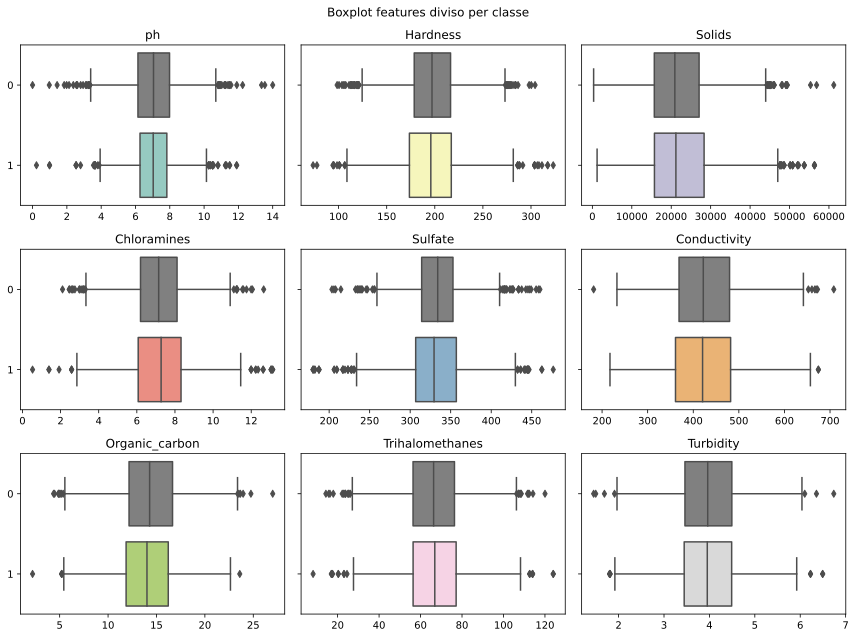

In [ ]:
# imposto il grafico
fig, axs = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(12, 9),
    sharey=True
)
axs = axs.ravel()

# itero attraverso le colonne del DataFrame per creare i diversi assi
for i, col in enumerate(df_train_imp.columns[0:-1]):
    sns.boxplot(
        data=df_train_imp,
        y="Potability",
        x=col,
        orient="h",
        palette=("gray",colors[i]),
        ax=axs[i]
    )

    axs[i].set_title(col)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")



# imposto titolo e layout
plt.suptitle(
    "Boxplot features diviso per classe",
    horizontalalignment="center"
)
plt.tight_layout()

I grafici mostrano la presenza di numerosi outliers per entrambe le classi della label.

calcolo il numero di outliers per ogni colonna

In [ ]:
# creo un dizionario in cui salvare gli indici degli outliers
outliers_dict = {
    'ph': [],
    'Hardness': [],
    'Solids': [],
    'Chloramines': [],
    'Sulfate': [],
    'Conductivity': [],
    'Organic_carbon': [],
    'Trihalomethanes': [],
    'Turbidity': []
}
# creo variabile di appoggio per salvare il numero totale di outliers
tot_outliers = 0

# creo un set di appoggio per salvare gli indici con outliers e non avere duplicati
outliers_set = set({})

# itero sulle classi del label
for label in [0, 1]:
    # itero sulle colonne
    for column in df_train_imp.columns[:-1]:
        # calcolo i margini per gli outliers
        q1 = df_train_imp.loc[df["Potability"] == label, column].quantile(0.25)
        q3 = df_train_imp.loc[df["Potability"] == label, column].quantile(0.75)
        iqr = q3 - q1
        lower_tail = q1 - 1.5 * iqr
        upper_tail = q3 + 1.5 * iqr

        # identifico gli outlirs
        outliers = df_train_imp[(df_train_imp["Potability"] == label) &
                      ((df_train_imp[column] > upper_tail) |
                       (df_train_imp[column] < lower_tail))].index.tolist()
        #aggiungo gli indici al dict
        outliers_dict[column].extend(outliers)
        outliers_set.update(outliers)

In [ ]:
# stampo a schermo numero outliers
for i, key in enumerate(outliers_dict.keys()):
    print(f"{key:16} {len(outliers_dict[key])}")
    tot_outliers += len(outliers_dict[key])
print()
print(f"TOT outliers =   {tot_outliers}")
print(f"numero di campioni con almeno un outlier: {len(outliers_set)}")

ph               78
Hardness         84
Solids           57
Chloramines      42
Sulfate          96
Conductivity     14
Organic_carbon   23
Trihalomethanes  40
Turbidity        16

TOT outliers =   450
numero di campioni con almeno un outlier: 395


calcolo percentuale outliers

In [ ]:
# calcolo il numero totale di campioni per ogni colonna
num_samples = df_train_imp.shape[0]

# calcolo il numero di outliers per ogni colonna
outliers_count = []
for column, outliers in outliers_dict.items():
    outliers_count.append(len(outliers))

# calcolo la percentuale di outliers per ogni colonna
outliers_percentage = (np.array(outliers_count) /
                       num_samples * 100)

# calcolo percentuale sul totale dei dati
tot_dati = df_train_imp.shape[0] * (df_train_imp.shape[1]-1)
tot_outliers_perc =  (tot_outliers /
                      tot_dati *
                      100)
samples_with_outliers_perc = (len(outliers_set) /
                              df_train_imp.shape[0] *
                              100)
# stampo a schermo
for i, key in enumerate(outliers_dict.keys()):
    print(f"{key:16} {outliers_percentage[i]:.2f}%")

print()
print(f"percentuale outliers sui dati totali = {tot_outliers_perc:.2f}%")
print(f"percentuale campioni con outliers =    {samples_with_outliers_perc:.2f}%")

ph               2.44%
Hardness         2.63%
Solids           1.78%
Chloramines      1.31%
Sulfate          3.00%
Conductivity     0.44%
Organic_carbon   0.72%
Trihalomethanes  1.25%
Turbidity        0.50%

percentuale outliers sui dati totali = 1.56%
percentuale campioni con outliers =    12.36%


Rappresento graficamente gli outliers trovati

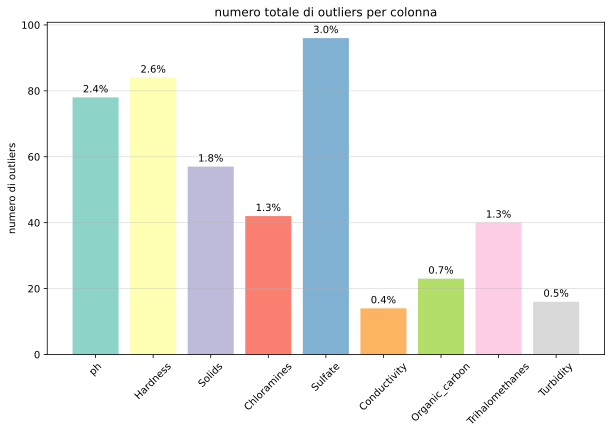

In [ ]:
# creo l'indice per le barre
ind = np.arange(len(outliers_dict.keys()))

# creo il grafico a barre
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ind,
              outliers_count,
              color=colors)
ax.grid(axis="y",
        alpha=0.4)

# aggiungo l'annotazione per la percentuale di outliers
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(f'{outliers_percentage[i]:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2,
                    height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom')

# imposto i nomi delle colonne come etichette sull'asse x
ax.set_xticks(ind)
ax.set_xticklabels(outliers_dict.keys(),
                   rotation=45,
                   ha='center')

# aggiungo etichette agli assi e titolo del grafico
ax.set_ylabel('numero di outliers')
ax.set_title('numero totale di outliers per colonna')

# mostro il grafico
plt.show()


L'analisi univariata degli outliers basata su IQR ha portato all'identificazione di 450 outliers (1.56% dei dati totali).

I campioni con almeno un outlier sono 395 (12.36% dei campioni totali).

La feature con più outliers è "Sulfate" con un totale di 96 outliers (3.0% della colonna).

La feature con meno outliers è "Conductivity" con un totale di 14 outliers (0.4% della colonna).

Vado ad eliminare gli outliers identificati nel dataset

In [ ]:
# creo una copia del dataset df_train_nonull per gli outliers univariati
df_train_out_uni = df_train_imp.copy()

In [ ]:
# elimino i campioni con outliers
df_train_out_uni.drop(index=list(outliers_set), inplace=True)

In [ ]:
# verifico che si siano eliminati 395 campioni
diff_shape = df_train_imp.shape[0] - df_train_out_uni.shape[0]
print(f"la differenza di campioni tra df_train_nonull e df_train_out_uni è di: {diff_shape} campioni")

la differenza di campioni tra df_train_nonull e df_train_out_uni è di: 395 campioni


In [ ]:
# divido il dataset df_train in X_train, y_train
X_train_out_uni = df_train_out_uni.drop(columns="Potability")
y_train_out_uni = df_train_out_uni["Potability"]

In [ ]:
# addestro baseline model
baseline_model.fit(X_train_out_uni, y_train_out_uni)

# predico y_test
y_pred_out_uni = baseline_model.predict(X_test_imputed)

# calcolo metriche
accuracy_out_uni = accuracy_score(y_test, y_pred_out_uni)
precision_out_uni = precision_score(y_test, y_pred_out_uni)

# stampo a schermo
print(f"accuratezza: {accuracy_out_uni:.3f}")
print(f"precisione: {precision_out_uni:.3f}")

accuratezza: 0.500
precisione: 0.370


i punteggi di accuracy e precision sono peggiorati rispetto all'addestramento con ouliers.
Provo un altra tecnica di individuazione degli outliers.

### Analisi multivariata

procedo all'identificazione degli outliers utilizzando una seconda tecnica di ricerca degli outliers: IsolationForest.
Questo modello analizza i campioni del dataset confrontandoli ed individuando quelli che hanno una certa diversità rispetto agli altri.

I parametri principali del modello sono:
- "contamination" che influenza il numero di outliers che il modello identifica.
- "n_estimators" che specifica il numero di alberi della foresta
- "max_samples" che specifica il numero di campioni su cui addestrare ogni albero


Per ottenere il risultato migliore, eseguo una ricerca dei parametri migliori andando ad addestrare il modello IsolationForest sul dataset provando diverse combinazini di parametri.
Per ogni addestramento ricavo una versione del dataset con diversi outliers eliminati.
Addestro infine il baseline model su tutte queste versioni del dataset per ricavare quale ottiene il punteggio migliore.

In [ ]:
# creo liste in cui salvare df modificati
X_train_out_multi = []
y_train_out_multi = []
multi_out_train = []


# creo una lista con i diversi tentativi dei parametri
param_grid = {
    "contamination": [
        0.05,
        0.10,
        0.15,
        0.20,
        "auto"
        ],
    "n_estimators": [
        10,
        30,
        100,
        300,
        1000
        ],
    "max_samples": [
        "auto",
        0.2,
        0.4,
        0.6,
        0.8
        ]
}

# creo tutte le possibili combinazioni di iperparametri
param_combinations = ParameterGrid(param_grid)

# creo le diverse versioni di df
for i, params in tqdm(enumerate(param_combinations),
                      total=len(param_combinations)):

    # addestro su X_train_imputed
    iso = IsolationForest(random_state=17, **params).fit(X_train_imputed.values, y_train)

    # ricavo gli outliers
    multi_out_train += [iso.predict(X_train_imputed.values)]

    # creo nuovo df senza outliers (1=inliers, -1=outliers)
    X_train_out_multi += [X_train_imputed[multi_out_train[i]==1]]
    y_train_out_multi += [y_train[multi_out_train[i]==1]]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
# addestro il baseline-model sulle diverse versioni di X_train
acc_out_multi = []
prec_out_multi = []
for i in tqdm(range(len(X_train_out_multi)),
              total=len(X_train_out_multi)):

    # addestro baseline model
    baseline_model.fit(X_train_out_multi[i], y_train_out_multi[i])

    # predico y_test
    y_pred_out_multi = baseline_model.predict(X_test_imputed)

    # calcolo metriche
    acc_out_multi += [accuracy_score(y_test, y_pred_out_multi)]
    prec_out_multi += [precision_score(y_test, y_pred_out_multi)]

  0%|          | 0/125 [00:00<?, ?it/s]

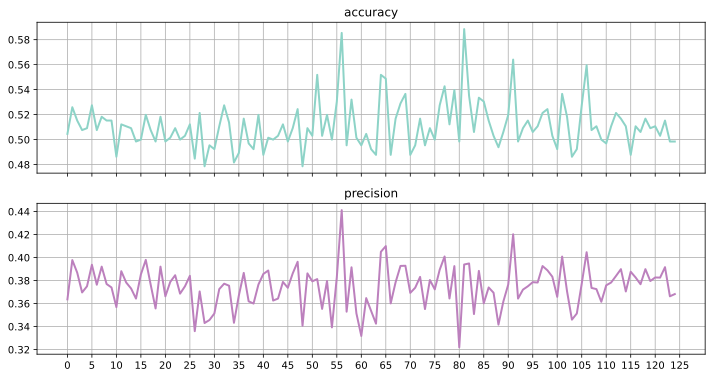

In [ ]:
# creo grafico dei risultati
fig, ax = plt.subplots(figsize=(12,6), sharex=True, nrows=2)

# accuratezza
ax[0].plot(acc_out_multi,
           color=colors[0],
           linewidth=2)
#precisione
ax[1].plot(prec_out_multi,
           color=colors[9],
           linewidth=2)

# imposto grafici
ax[0].set_xticks(range(0,126,5))
ax[0].set_title("accuracy")
ax[1].set_title("precision")
ax[0].grid()
ax[1].grid()


Sembra che la combinazione migliore di parametri per IsolationForest sia la numero 56, con accuratezza di circa 0.585 e precisione sopra a 0.44.

In [ ]:
# stampo a schermo risultati
print(f"tentativo migliore: n.56")
print(f"accuratezza:        {acc_out_multi[56]:.3f}")
print(f"precisione:         {prec_out_multi[56]:.3f}")
print("")
print(f"la combinazione di parametri migliori per Isolation forest è:")
print(param_combinations[56])

tentativo migliore: n.56
accuratezza:        0.585
precisione:         0.441

la combinazione di parametri migliori per Isolation forest è:
{'n_estimators': 30, 'max_samples': 0.2, 'contamination': 0.15}


In [ ]:
# conto il numero di outliers eliminati
n_out = len(multi_out_train[56][multi_out_train[56]==-1])
print(f"numero outliers identificati ed eliminati: {n_out}")

numero outliers identificati ed eliminati: 480


In [ ]:
# salvo i dati senza outliers (no out)
X_train_nout = X_train_out_multi[56].reset_index(drop=True)
y_train_nout = y_train_out_multi[56].reset_index(drop=True)

# per comodità rinomino anche il test con stessa dicitura
X_test_nout = X_test_imputed.reset_index(drop=True)
y_test_nout = y_test.reset_index(drop=True)

0    1383
1    1333
Name: Potability, dtype: int64


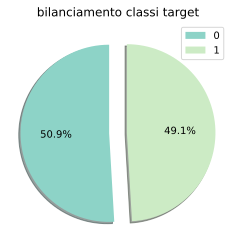

In [ ]:
# verifico il bilanciamento delle classi dopo l'eliminazione degli outliers
class_count_nout = y_train_nout.value_counts()
print(class_count_nout)

# creo il grafico a torta
plt.figure(figsize=(4, 4))
plt.pie(
    class_count_nout,
    colors=(colors[0], colors[10]),
    autopct="%1.1f%%",
    startangle=90,
    shadow=True,
    explode=[0.1,0.1]

)
plt.title("bilanciamento classi target")
plt.legend([0,1], )
plt.show()

L'analisi multivariata degli outliers con IsolationForest ha portato risultati migliori rispetto all'analisi univariata con tecnica dell'IQR.

Dopo leliminazione dei valori anomali il dataset è rimasto abbastanza bilanciato con uno scostamento dal bilanciamento perfeto 50/50 di meno dell'1% (50.9% e 49.1%).

Mantengo quindi come dataset df_train_nout come train set.

## Standardizzazione

Procedo a standardizzare i dati.

Utilizzo per questo processo StandardScaler che permette la trasformazione dei dati in modo che abbiano una media zero e una deviazione standard unitaria.


In [ ]:
# definisco lo scaler
scaler = StandardScaler().fit(X_train_nout)

# scalo i dati di train
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_nout),
    columns=X_train_nout.columns
    ).reset_index(drop=True)

# scalo i dati di test (con info solo da X_train)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_nout),
    columns=X_test_nout.columns
    ).reset_index(drop=True)

In [ ]:
# rinomino i dataset

df_train_scaled = pd.concat(
    [X_train_scaled, y_train_nout],
    axis=1
    ).reset_index(drop=True)

df_test_scaled = pd.concat(
    [X_test_scaled, y_test_nout],
    axis=1
    ).reset_index(drop=True)

## Correlazioni

<Axes: >

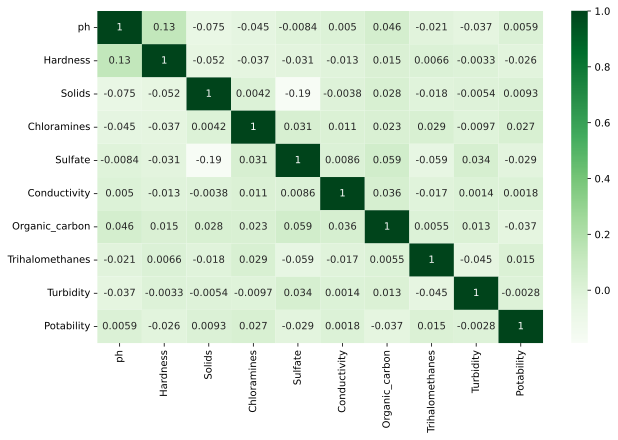

In [ ]:
# creo matrice di correlazione
plt.figure(figsize=(10,6))

sns.heatmap(df_train_scaled.corr(),
            annot=True,
            cmap="Greens")

La matrice di correlazione mostra che le correlazioni lineari tra le features sono molto deboli (tutti i valori sono molto vicino a 0).
Questo indica che i diversi parametri dell'acqua misurati non si influenzano in modo lineare l'uno con l'altro, ma ciò non esclude possibili correlazioni non lineari.  
Questo implica che modelli lineari probabilmente non riusciranno a prevedere in modo adeguato il target.

## Selezione features

Per identificare se la media delle feature nei campioni con label = 0 è significativamente differente dalla media nei campioni con label = 1 utilizzo il t-test di Student per confrontare le medie dei due gruppi. (non il chi quadrato in quanto è adatto a solo variabili categoriche)

Ipotesi del Test:
- Ipotesi nulla (H0): Non ci sono differenze statisticamente significative tra le medie dei due gruppi.
- Ipotesi alternativa (H1): Esistono differenze statisticamente significative tra le medie dei due gruppi.

Il t-test per campioni indipendenti viene utilizzato per confrontare le medie delle feature tra i gruppi label 0 e label 1. Questo permette di identificare le feature con differenze statisticamente significative tra i due gruppi. Inoltre, l'analisi delle feature potrebbe aiutarmi a selezionare quelle che influenzano maggiormente la previsione del target.


In [ ]:
# Separa le feature continue dal DataFrame e la variabile di classe (label)
features = df_train_scaled.drop('Potability', axis=1)
label = df_train_scaled['Potability']

# Esegui il t-test per ciascuna feature rispetto alla variabile di classe (label)
t_test_report = {}
for feature in features.columns:
    group0 = features.loc[label == 0, feature]
    group1 = features.loc[label == 1, feature]
    t_statistic, p_value = ttest_ind(group0, group1)
    t_test_report[feature] = p_value

t_test_report = sorted(t_test_report.items(),
                       key=lambda item: item[1])
for key, value in t_test_report:
    print(f"{key:15}: {value:.3f}")

Organic_carbon : 0.055
Sulfate        : 0.132
Chloramines    : 0.155
Hardness       : 0.177
Trihalomethanes: 0.446
Solids         : 0.630
ph             : 0.757
Turbidity      : 0.885
Conductivity   : 0.925


In questo caso i valori di p sono relativamente alti (tutti sopra lo standard dello 0.05), ciò significa che c'è un rischio relativamente alto che le differenze dei due gruppi siano dovute al caso e non a differenze reali dei due gruppi.

Si nota comunque una differenza abbastanza netta tra i valori p delle prime 4 features (p < 0.18) e le restanti (p > 0.44).
Seleziono quindi queste features come le più rilevanti:
- Organic_carbon
- Sulfate
- Chloramines
- Hardness


Creo due dataset diversi, uno con tutte le features ed uno con le sole 4 più rilevanti.

Successivamente andrò ad addestrare diversi modelli su questi due dataset per ottenere il modello migliore.

In [ ]:
# creo i dataset per l'analisi, con tutte le features e con solo le 4 migliori

# dati con tutte le features
X_train_1 = df_train_scaled.drop("Potability", axis=1)
X_test_1 = df_test_scaled.drop("Potability", axis=1)

# dati con solo 4 features
X_train_2 = X_train_1[["Organic_carbon", "Sulfate", "Chloramines", "Hardness"]]
X_test_2 = X_test_1[["Organic_carbon", "Sulfate", "Chloramines", "Hardness"]]

# label comune ad entrambi i dataset
y_train = df_train_scaled["Potability"]
y_test = df_test_scaled["Potability"]




# Metrica di valutazione

Vado ad esaminare le diverse metriche di valutazione utilizzabili in questo contesto per poter scegliere la metrica più adeguata.

Abbreviazioni:   
TP = True Positive.
TN = True Negative.
FP = False Positive.
FN = False Negative.

**Accuracy (Accuratezza):**  
L'accuratezza misura la frazione di previsioni corrette rispetto al totale delle previsioni. È la metrica più comune ma può essere fuorviante se le classi sono sbilanciate e non da indicazioni sul tipo di errore commesso dal modello.  
Formula: (TP + TN) / (TP + TN + FP + FN).

**Precision (Precision):**  
La precisione rappresenta la frazione di previsioni positive corrette rispetto al totale delle previsioni positive fatte dal modello. È importante quando è rilevante non avere troppi errori falsi positivi.  
Formula: TP / (TP + FP).

**Recall (Richiamo o Sensibilità):**  
Il recall misura la frazione di veri positivi individuati dal modello rispetto al totale dei veri positivi presenti nel dataset. È importante quando il costo degli errori falsi negativi è alto.  
Formula: TP / (TP + FN).

**Specificità:**  
La specificità rappresenta la capacità di un modello di identificare correttamente i casi negativi rispetto al totale dei casi negativi presenti nel dataset. In altre parole, misura quanto bene il modello è in grado di riconoscere correttamente i veri negativi. E' particolarmente importante in situazioni in cui identificare correttamente i casi negativi è di grande rilevanza.  
Formula: TN / (TN + FP).

**F1-Score:**  
L'F1-score è la media armonica di precisione e recall. È utile quando si vuole trovare un equilibrio tra precisione e recall.  
Formula: 2 * (Precision * Recall) / (Precision + Recall).

**AUC-ROC (Area Under the ROC Curve):**  
La curva ROC (Receiver Operating Characteristic Curve) è un grafico che rappresenta il tasso di veri positivi (sensibilità) rispetto al tasso di falsi positivi (1-specificità) al variare della soglia di classificazione.
L'AUC-ROC è l'area sotto la curva ROC e fornisce una misura aggregata della capacità di separazione del modello tra le classi. Valori più vicini a 1 indicano un modello migliore.  

**AUC-PR (Area Under the Precision-Recall Curve):**  
L'AUC-PR è l'area sotto la curva precision-recall. È particolarmente utile quando si hanno classi sbilanciate e ci si concentra sui veri positivi. Valori più alti indicano un modello migliore.  

**Log Loss (Logarithmic Loss):**  
La log loss misura la discrepana tra le probabilità previste dal modello e le etichette reali. Per questo motivo, a differenza ad esempio di accuracy, penalizza maggiormente gli "errori gravi" e da più peso ai campioni che con più probabilità appartengono ad una determinata classe.

**Confusion Matrix (Matrice di Confusione):**  
La matrice di confusione, non è una vera e propria metrica, me è una tabella che mostra il numero di previsioni corrette e errori suddivisi per classe. È utile per comprendere in dettaglio le prestazioni del modello in quanto permette di visualizzare simultaneamente falsi positivi, falsi negativi, veri positivi e veri negativi.


Nell'analisi in questione verrà utilizzata prevalente l'accuratezza come metrica di valutazione dei modelli.

# Definizione modelli

I modelli che paragono in questo progetto sono 3:
- Logistic Regression
- Random Forest Classifier
- K-Nearest Neighbors

Seguo due differenti strade:
1. Utilizzo di tutte le features
2. Utilizzo solo le features selezionate con il t_test (con valori di p minori)



## Strada 1 (tutte le features)

### Spot check

verifico velocemente quale tipologia di modello ha le migliori prestazioni su questo dataset

Lo spot check segue le stesse fasi per tutti e tre i modelli:  
Per prima cosa imposto la divisione in kfold con stratifiedkfold in modo da avere la sicurezza che gli split mantengano le classi bilanciate.  
Successivamente definisco il modello ed imposto alcuni iperparametri se necessario.  
Infine calcolo il punteggio di accuratezza con la funzione cross_val_score.


#### Logistic Regression

In questo caso imposto alcuni parametri fondamentali del modello:   
- aumento a 1000 il numero di max_iter per aver la sicurezza che il modello arrivi a convergenza,   
- imposto il random_state per avere ripetibilità nella previsione,  
- imposto multi_class uguale a "ovr" in quanto il dataset ha un target binario.  

In [ ]:
# imposto la divisione in k folds stratificati
folds = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=17)

In [ ]:
# imposto il modello
LR_model = LogisticRegression(max_iter=1000,
                              random_state=17,
                              multi_class="ovr")

# calcolo l'accuracy
LR_results_1 = cross_val_score(
    LR_model,
    X_train_1,
    y_train,
    cv=folds,
    scoring="accuracy"
    )
# stampo i risultati
print(f"accuracy = {LR_results_1.mean():.3f}")

accuracy = 0.522


#### K-Nearest Neighbors
Eseguo uno spot check anche per il modello K-nearest neighbors (KNN).

In [ ]:
# imposto il modello
KNN_model = KNeighborsClassifier()

# calcolo l'accuracy
KNN_results_1 = cross_val_score(
    KNN_model,
    X_train_1,
    y_train,
    cv=folds,
    scoring="accuracy"
    )
# stampo i risultati
print(f"accuracy = {KNN_results_1.mean():.3f}")

accuracy = 0.653


#### Random Forest Classifier
Eseguo lo spot check sul modello Rsandom Forest Classifier (RFC).

In [ ]:
# imposto il modello
RFC_model = RandomForestClassifier(random_state=17)

# calcolo l'accuracy
RFC_results_1 = cross_val_score(
    RFC_model,
    X_train_1,
    y_train,
    cv=folds,
    scoring="accuracy"
    )
# stampo i risultati
print(f"accuracy = {RFC_results_1.mean():.3f}")

accuracy = 0.828


### Tuning parametri

Mantengo i due modelli che hanno ottenuto i punteggi migliori nello spot check, ovvero KNN e RFC, e ottimizzo i loro iperparametri utilizzando la cross validation e la grid search.

Per ottenere risultati più relaistici e che possano ottenere prestazioni adeguate anche con nuovi dati mai visti, applico la regola del un errore standard (One Stanrd Error Rule) secondo cui, invece di mantenere la combinazione di parametri che ha ottenuto il miglior punteggio, si mantiene il modello che ha ottenuto il punteggio migliore meno una volta l'errore standard. Questo procedimento dovrebbe consentire al modello di non fare overfitting sui dati di train.

L'errore standard viene calcolato come la deviazione standard diviso la radice quadrata dei fold di addestramento.


#### KNN tuning

In [ ]:
# definisco i parametri da ottimizzare
KNN_params = {
  'n_neighbors': np.arange(1,51,5), # numero di vicini da considerare
  'weights': ['distance', 'uniform'],  # tipo di pesatura
  'p': [1,2],  # 1 per distanza di Manhattan, 2 per distanza euclidea
  'algorithm':['brute', 'kd_tree', 'ball_tree', 'auto', ]
}

# imposto la ricerca dei parametri
KNN_grid_search_1 = GridSearchCV(
    scoring="accuracy",
    estimator=KNN_model,
    param_grid=KNN_params,
    cv=folds,
    n_jobs=-1,
    refit=True,
    verbose=1)

# addestro il modello
KNN_grid_search_1.fit(X_train_1, y_train)

# stampo i migliori parametri e il punteggio migliore
print("Migliori parametri:", KNN_grid_search_1.best_params_)
print(f"Punteggio migliore: {KNN_grid_search_1.best_score_:.3f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Migliori parametri: {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
Punteggio migliore: 0.763


In [ ]:
# calcolo punteggi e parametri
best_score = KNN_grid_search_1.best_score_
best_index = KNN_grid_search_1.best_index_
er_std = KNN_grid_search_1.cv_results_['std_test_score'][best_index] / np.sqrt(5)
OSER_score = best_score - er_std
OSER_index = np.argmin(np.abs(KNN_grid_search_1.cv_results_['mean_test_score'] - OSER_score))
OSER_params = KNN_grid_search_1.cv_results_["params"][OSER_index]

print(f"acc. migliore:   {best_score:.3f}")
print(f"Errore Standard: {er_std:.3f}")
print(f"OSER score:      {OSER_score:.3f}")
print(f"OSER index:      {OSER_index}")
print(f"OSER params:     {OSER_params}")




acc. migliore:   0.763
Errore Standard: 0.008
OSER score:      0.755
OSER index:      32
OSER params:     {'algorithm': 'brute', 'n_neighbors': 41, 'p': 1, 'weights': 'distance'}


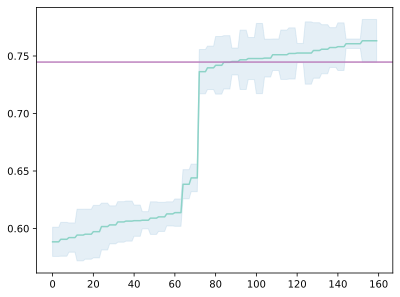

In [ ]:
# plotto l'anadamento dei risultati
sorted_index_acc = np.argsort(KNN_grid_search_1.cv_results_['mean_test_score'])
acc_array = KNN_grid_search_1.cv_results_['mean_test_score'][sorted_index_acc]
std_array = KNN_grid_search_1.cv_results_['std_test_score'][sorted_index_acc]
OSER_acc = (acc_array - std_array)[-1]
cv_attempts = list(range(0, len(acc_array)))

plt.plot(acc_array, color=colors[0])
plt.fill_between(cv_attempts,
                 acc_array-std_array,
                 acc_array+std_array,
                 alpha=0.2,
                 color=colors[4])
plt.axhline(OSER_acc,
            color=colors[9])


#### RFC tuning

Visto che RandomForestClassifier ha diversi parametri da validare e con diversi valori possibili, eseguo prima una RandomSearch in modo da eseguire un numero prestabilito di tentativi utilizzando combinazioni casuali di parametri. Questo mi permette di individuare uno spazio di parametri più ristretto su cui poi eseguire una GridSearch esaustiva e trovare così i parametri ottimali.

In [ ]:
# definisco i parametri da validare
RFC_params = {
    'n_estimators': np.arange(10,160,20), # numero di alberi nella foresta
    'max_depth': np.arange(10,160,20), # massima profondità degli alberi
    'max_features':  [0.2,0.4,0.6,0.8], # numero massimo di features da considerare
    'max_samples': [0.4,0.6,0.8,1.0], #numero di campioni su cui addestrare gli alberi (bootstrap=True)
    #'min_samples_split': np.arange(2,22,2),
    #'min_samples_leaf': np.arange(1,10,2)
}

# imposto la ricerca casuale
RFC_random_search_1 = RandomizedSearchCV(
    scoring="accuracy",
    estimator=RFC_model,
    param_distributions=RFC_params,
    n_iter=200,  # numero di combinazioni casuali da provare
    cv=folds,
    n_jobs=-1,
    refit=True,
    verbose=1)

RFC_random_search_1.fit(X_train_1, y_train)

# stampo i migliori parametri e il punteggio migliore
print("Migliori parametri:", RFC_random_search_1.best_params_)
print(f"Punteggio migliore: {RFC_random_search_1.best_score_:.3f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Migliori parametri: {'n_estimators': 150, 'max_samples': 1.0, 'max_features': 0.2, 'max_depth': 50}
Punteggio migliore: 0.838


In [ ]:
best_score = RFC_random_search_1.best_score_
best_index = RFC_random_search_1.best_index_
er_std = RFC_random_search_1.cv_results_['std_test_score'][best_index] / np.sqrt(5)
OSER_score = best_score - er_std
OSER_index = np.argmin(np.abs(RFC_random_search_1.cv_results_['mean_test_score'] - OSER_score))
OSER_params = RFC_random_search_1.cv_results_["params"][OSER_index]

print(f"acc. migliore:   {best_score:.3f}")
print(f"Errore Standard: {er_std:.3f}")
print(f"OSER score:      {OSER_score:.3f}")
print(f"OSER index:      {OSER_index}")
print(f"OSER params:     {OSER_params}")

acc. migliore:   0.838
Errore Standard: 0.005
OSER score:      0.833
OSER index:      75
OSER params:     {'n_estimators': 110, 'max_samples': 1.0, 'max_features': 0.2, 'max_depth': 50}


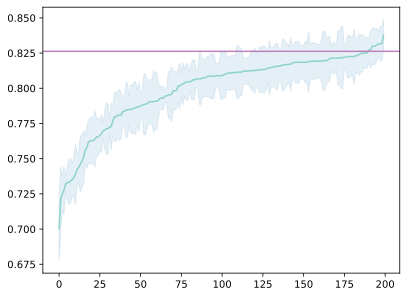

In [ ]:
# plotto l'anadamento dei risultati
sorted_index_acc = np.argsort(RFC_random_search_1.cv_results_['mean_test_score'])
acc_array = RFC_random_search_1.cv_results_['mean_test_score'][sorted_index_acc]
std_array = RFC_random_search_1.cv_results_['std_test_score'][sorted_index_acc]
OSER_acc = (acc_array - std_array)[-1]
cv_attempts = list(range(0, len(acc_array)))

plt.plot(acc_array, color=colors[0])
plt.fill_between(cv_attempts,
                 acc_array-std_array,
                 acc_array+std_array,
                 alpha=0.2,
                 color=colors[4])
plt.axhline(OSER_acc,
            color=colors[9])


Il modello Random Forest ha ottenuto risultati di accuratezza migliori rispetto a KNN: 0.833 contro 0.755.

## Strada 2 (con 4 features)

### Spot check

verifico velocemente quale tipologia di modello ha le migliori prestazioni su questo dataset

Le fasi dello spot check sono le stesse che ho eseguito precedentemente, ma kfold ed i modelli sono gia stati impostati quindi procedo direttamente al calcolo dell'accuratezza con cross validation.

#### Logistic Regression

In questo caso imposto alcuni parametri fondamentali del modello:   
- aumento a 1000 il numero di max_iter per aver la sicurezza che il modello arrivi a convergenza,   
- imposto il random_state per avere ripetibilità nella previsione,  
- imposto multi_class uguale a "ovr" in quanto il dataset ha un target binario.  

In [ ]:
# calcolo l'accuracy
LR_results = cross_val_score(
    LR_model,
    X_train_2,
    y_train,
    cv=folds,
    scoring="accuracy"
    )
# stampo i risultati
print(f"accuracy = {LR_results.mean():.3f}")

accuracy = 0.538


#### K-Nearest Neighbors
Eseguo uno spot check anche per il modello K-nearest neighbors (KNN).

In [ ]:
# calcolo l'accuracy
KNN_results = cross_val_score(
    KNN_model,
    X_train_2,
    y_train,
    cv=folds,
    scoring="accuracy"
    )
# stampo i risultati
print(f"accuracy = {KNN_results.mean():.3f}")

accuracy = 0.605


#### Random Forest Classifier
Eseguo lo spot check sul modello Random Forest Classifier (RFC).

In [ ]:
# calcolo l'accuracy
RFC_results = cross_val_score(
    RFC_model,
    X_train_2,
    y_train,
    cv=folds,
    scoring="accuracy"
    )
# stampo i risultati
print(f"accuracy = {RFC_results.mean():.3f}")

accuracy = 0.791


### Tuning parametri

Mantengo i due modelli che hanno ottenuto i punteggi migliori nello spot check, ovvero KNN e RFC, e ottimizzo i loro iperparametri utilizzando la cross validation e la grid search.

#### KNN tuning

In [ ]:
# imposto la ricerca casuale
KNN_grid_search_2 = GridSearchCV(
    scoring="accuracy",
    estimator=KNN_model,
    param_grid=KNN_params,
    cv=folds,
    n_jobs=-1,
    refit=True,
    verbose=1)

# addestro il modello
KNN_grid_search_2.fit(X_train_2, y_train)

# stampo i migliori parametri e il punteggio migliore
print("Migliori parametri:", KNN_grid_search_2.best_params_)
print(f"Punteggio migliore: {KNN_grid_search_2.best_score_:.3f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Migliori parametri: {'algorithm': 'brute', 'n_neighbors': 46, 'p': 1, 'weights': 'distance'}
Punteggio migliore: 0.751


In [ ]:
best_score = KNN_grid_search_2.best_score_
best_index = KNN_grid_search_2.best_index_
er_std = KNN_grid_search_2.cv_results_['std_test_score'][best_index] / np.sqrt(5)
OSER_score = best_score - er_std
OSER_index = np.argmin(np.abs(KNN_grid_search_2.cv_results_['mean_test_score'] - OSER_score))
OSER_params = KNN_grid_search_2.cv_results_["params"][OSER_index]

print(f"acc. migliore:   {best_score:.3f}")
print(f"Errore Standard: {er_std:.3f}")
print(f"OSER score:      {OSER_score:.3f}")
print(f"OSER index:      {OSER_index}")
print(f"OSER params:     {OSER_params}")




acc. migliore:   0.751
Errore Standard: 0.006
OSER score:      0.745
OSER index:      24
OSER params:     {'algorithm': 'brute', 'n_neighbors': 31, 'p': 1, 'weights': 'distance'}


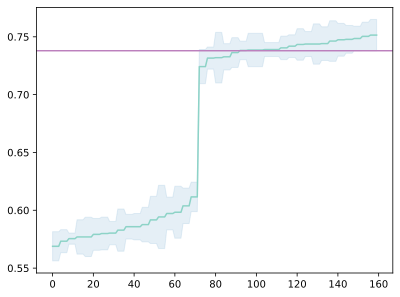

In [ ]:
# plotto l'anadamento dei risultati
sorted_index_acc = np.argsort(KNN_grid_search_2.cv_results_['mean_test_score'])
acc_array = KNN_grid_search_2.cv_results_['mean_test_score'][sorted_index_acc]
std_array = KNN_grid_search_2.cv_results_['std_test_score'][sorted_index_acc]
OSER_acc = (acc_array - std_array)[-1]
cv_attempts = list(range(0, len(acc_array)))

plt.plot(acc_array, color=colors[0])
plt.fill_between(cv_attempts,
                 acc_array-std_array,
                 acc_array+std_array,
                 alpha=0.2,
                 color=colors[4])
plt.axhline(OSER_acc,
            color=colors[9])


#### RFC tuning

Anche in questo caso eseguo prima una RandomSearch e poi successivamente una GridSearch attorno ai migliori parametri trovati.

In [ ]:
# imposto la ricerca casuale
RFC_random_search_2 = RandomizedSearchCV(
    scoring="accuracy",
    estimator=RFC_model,
    param_distributions=RFC_params,
    n_iter=200,  # numero di combinazioni casuali da provare
    cv=folds,
    n_jobs=-1,
    refit=True,
    verbose=1)

RFC_random_search_2.fit(X_train_2, y_train)

# stampo i migliori parametri e il punteggio migliore
print("Migliori parametri:", RFC_random_search_2.best_params_)
print(f"Punteggio migliore: {RFC_random_search_2.best_score_:.3f}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Migliori parametri: {'n_estimators': 70, 'max_samples': 1.0, 'max_features': 0.2, 'max_depth': 50}
Punteggio migliore: 0.800


In [ ]:
best_score = RFC_random_search_2.best_score_
best_index = RFC_random_search_2.best_index_
er_std = RFC_random_search_2.cv_results_['std_test_score'][best_index] / np.sqrt(5)
OSER_score = best_score - er_std
OSER_index = np.argmin(np.abs(RFC_random_search_2.cv_results_['mean_test_score'] - OSER_score))
OSER_params = RFC_random_search_2.cv_results_["params"][OSER_index]

print(f"acc. migliore:   {best_score:.3f}")
print(f"Errore Standard: {er_std:.3f}")
print(f"OSER score:      {OSER_score:.3f}")
print(f"OSER index:      {OSER_index}")
print(f"OSER params:     {OSER_params}")




acc. migliore:   0.800
Errore Standard: 0.006
OSER score:      0.794
OSER index:      141
OSER params:     {'n_estimators': 90, 'max_samples': 1.0, 'max_features': 0.4, 'max_depth': 30}


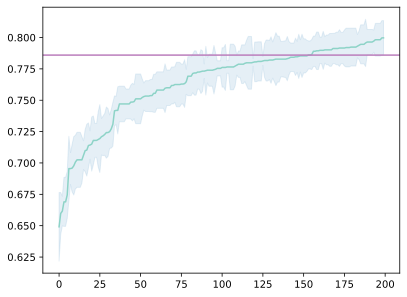

In [ ]:
# plotto l'anadamento dei risultati
sorted_index_acc = np.argsort(RFC_random_search_2.cv_results_['mean_test_score'])
acc_array = RFC_random_search_2.cv_results_['mean_test_score'][sorted_index_acc]
std_array = RFC_random_search_2.cv_results_['std_test_score'][sorted_index_acc]
OSER_acc = (acc_array - std_array)[-1]
cv_attempts = list(range(0, len(acc_array)))

plt.plot(acc_array, color=colors[0])
plt.fill_between(cv_attempts,
                 acc_array-std_array,
                 acc_array+std_array,
                 alpha=0.2,
                 color=colors[4])
plt.axhline(OSER_acc,
            color=colors[9])


Anche in questo caso RFC ha ottenuto punteggi di accuracy migliori rispetto a KNN. 0.745 di KNN contro i 0.794 di RFC.

# Addestramento finale

Per entrambe le strade RFC si è dimostrato il modello migliore.
Testo entrambi i modelli sul test set per identificare il migliore tra i due.

In [ ]:
# imposto il modello con i migliori parametri individuati durante la cv
RFC_final_1 = RandomForestClassifier(
    n_estimators = 130,
    max_samples = 0.6,
    max_features = 0.2,
    max_depth = 30
)

RFC_final_1.fit(X_train_1, y_train)

RandomForestClassifier(max_depth=30, max_features=0.2, max_samples=0.6,
                       n_estimators=130)

accuratezza 1: 0.640
precisione 1:  0.581


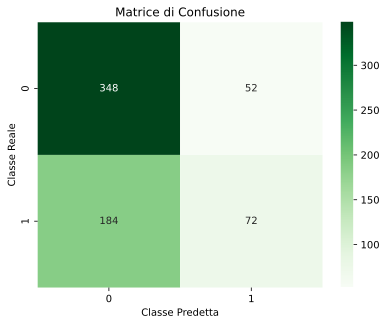

In [ ]:
# predico il test e calcolo metriche
y_pred_1 = RFC_final_1.predict(X_test_1)
acc_1 = accuracy_score(y_test, y_pred_1)
prec_1 = precision_score(y_test, y_pred_1)
c_matrix_1 = confusion_matrix(y_test, y_pred_1)

print(f"accuratezza 1: {acc_1:.3f}")
print(f"precisione 1:  {prec_1:.3f}")

# rappresento matrice di confusione
sns.heatmap(c_matrix_1, annot=True, fmt='d', cmap="Greens")

# aggiungo titoli e etichette degli assi
plt.title('Matrice di Confusione')
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')

plt.show()

In [ ]:
# imposto il modello con i migliori parametri trovati durante la cv
RFC_final_2 = RandomForestClassifier(
    n_estimators = 50,
    max_samples = 1.0,
    max_features = 0.4,
    max_depth = 70
)

RFC_final_2.fit(X_train_2, y_train)

RandomForestClassifier(max_depth=70, max_features=0.4, max_samples=1.0,
                       n_estimators=50)

accuratezza 2: 0.590
precisione 2:  0.453


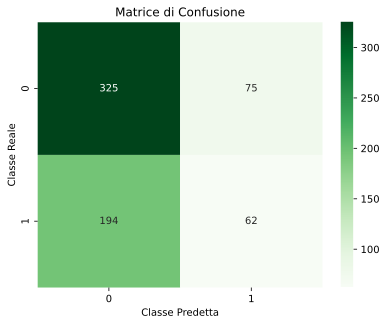

In [ ]:
# faccio previsione sul test e calcolo metriche
y_pred_2 = RFC_final_2.predict(X_test_2)
acc_2 = accuracy_score(y_test, y_pred_2)
prec_2 = precision_score(y_test, y_pred_2)
c_matrix_2 = confusion_matrix(y_test, y_pred_2)

print(f"accuratezza 2: {acc_2:.3f}")
print(f"precisione 2:  {prec_2:.3f}")

# rappresento matrice di confusione
sns.heatmap(c_matrix_2, annot=True, fmt='d', cmap="Greens")

# aggiungo titoli e etichette degli assi
plt.title('Matrice di Confusione')
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')

plt.show()

# Conclusioni

I risultati mostrano che il modello RFC_final_1 addestrato su tutte le features ha ottenuto un risultato leggermente migliore rispetto al modello addestrato solamente sulle quattro features più rilevanti (RFC_final_2).

RFC_final_1 ha ottenuto un punteggio sul test set di accuracy pari a 0.636 e  precision pari a 0.57.

Si notà inoltre che entrambi i modelli hanno ottenuto un punteggio significativamente inferiore nel test set piuttosto che durante l'addestramento. Questo probabilmente indica che, nonostante la cross validation, i modelli si sono adattati eccessivamente ai dati di train non riuscendo a generalizzare su nuovi dati: OVERFITTING.

Le previsioni ottenute mostrano un notevole sbilanciamento verso la classe 0. Ciò indica che il modello tende a predire con maggiore probabilità che l'acqua non sia potabile. Questa caratteristica è vantaggiosa per il dataset in questione poiché, dato il maggior numero di falsi negativi rispetto ai falsi positivi, è meno probabile che il modello identifichi erroneamente come potabile un campione d'acqua che in realtà non lo è. Questo è essenziale per garantire la sicurezza della salute. Tuttavia, la precisione rimane relativamente bassa, pari al 0.57, indicando che c'è una probabilità del 43% che un campione classificato come potabile non lo sia effettivamente.

Ipotizzo che la causa della bassa performance del modello sia causata principalmente dalla natura dei dati: dalla bassa correlazione tra le features ed il target, dalla bassa dimensionalità e dal rumore.





Converto in pdf

In [ ]:
!cp "drive/My Drive/Colab Notebooks/Progetto Finale Data Science di Tommaso Ciampolini.ipynb" ./
!jupyter nbconvert --to PDF "Progetto Finale Data Science di Tommaso Ciampolini.ipynb"

[NbConvertApp] Converting notebook Progetto Finale Data Science di Tommaso Ciampolini.ipynb to PDF
[NbConvertApp] Support files will be in Progetto Finale Data Science di Tommaso Ciampolini_files/
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso Ciampolini_files
[NbConvertApp] Making directory ./Progetto Finale Data Science di Tommaso C